In [1]:
# All modules that  is needed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline   

import rubin_sim.maf as maf
from rubin_sim.maf.maps import dustMap
#from rubin_sim.photUtils import Dust_values
#from rubin_sim.maf.metrics import crowdingMetric




from PulsatingStarRecovery_XLynne_blend import PulsatingStarRecovery

In [2]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)


#or take a new Opsim from the path (new http://astro-lsst-01.astro.washington.edu:8080/allMetricResults?runId=1)
#opsim_fname='/sims_maf/fbs_2.0/baseline/baseline_v2.0_10yrs.db'
#runName='baseline_v2.0_10yrs.db'




/sims_maf/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs


In [3]:
# Connect to the database so we can use it with MAF.
opsim_db = maf.OpsimDatabase(opsim_fname)
#Finding available database columns with which to express constraints, slices, and metrics
#opsim_db.get_column_names("observations")


In [4]:
# Specify ra / dec of the point we want to work with on the sky - in degrees. 
# (these can be lists, if you want to work on multiple, limited points on the sky)
test_ra =270.8839167   
test_dec =-30.0352667

test_slicer = maf.UserPointsSlicer(test_ra, test_dec)
#test_slicer = maf.OneDSlicer(test_ra, test_dec)
maps = ['DustMap']


#test_ra =270.8839167   
#test_dec =-30.0352667
#ra=72.000005
#dec=-70.933132


In [5]:
#This cell  build DataFrame df that contains  the  list of blending stars with magnitudes . Can be empty if you don't wont to consider blending or if you are offline.
#In that case comment from import to print

dati=[]
df=pd.DataFrame(dati,columns=[])

import dl.queryClient as qc
test_ra = test_ra
test_dec = test_dec
table = 'lsst_sim.simdr2'
radius = 0.0002
query = "select ra,dec,umag,gmag, rmag, imag, zmag, ymag, mu0, gc, mass from {} where q3c_radial_query(ra, dec, {}, {}, {})".format(table,test_ra,test_dec,radius)
df = qc.query(sql=query ,timeout=1000, fmt='pandas') 
print(df)

 

           ra        dec    umag    gmag    rmag    imag    zmag    ymag  \
0  270.883756 -30.035409  29.475  26.248  24.683  23.300  22.587  22.217   
1  270.883803 -30.035364  28.944  25.712  24.158  22.791  22.088  21.724   
2  270.883866 -30.035426  24.411  21.688  20.454  19.935  19.599  19.417   
3  270.884056 -30.035187  31.878  28.551  26.807  25.606  24.941  24.603   

     mu0  gc   mass  
0  14.35   4  0.607  
1  13.90   4  0.611  
2  15.05   4  1.042  
3  16.00   1  0.466  


In [6]:
#parameters that must be inserted to run the metric PulsatingStarRecovery.py.Possible filenames are (https://github.com/MARCELLADC/PulsatingStarRecovery):
#filename='./RRab.csv'
#filename='./RRc.csv'
#filename='./CEF1.csv'
#filename='./CEF2.csv'
#filename='./LPV1.csv'
#filename='./LPV2.csv'
filename='./RRc.csv'   #ascii file with the template of pulsating star
dmod=14.5    #distance modulus
sigmaFORnoise=1   # sigma for the computation of the error on the magnitude
do_remove_saturated=True    #Remove from temporal series saurated visits  
factorForDimensionGap=0.5  #parameter used in LcSampling 
numberOfHarmonics=3         #parameter used in LcFitting--suggested value for a RRC





mymetric = PulsatingStarRecovery(filename,dmod,sigmaFORnoise,do_remove_saturated,numberOfHarmonics,factorForDimensionGap,df)
#if you are interested in other metrics
#maf.BaseMetric.help(doc=True)

./RRc.csv


In [7]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
#sqlconstraint = None   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
# sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 700'  # only use visits in the first year of the survey
sqlconstraint = 'night < 365'

In [8]:
bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint,maps)

In [14]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'PulsatingStarRecovery': bundle}, opsim_db, outDir='./', resultsDb=None)
# And calculate the metric
#from rubin_sim.maf.metrics import crowdingMetric
#import time
#start_time = time.time()
g.runAll()
#print("--- %s seconds ---" % (time.time() - start_time))

Querying database observations with constraint night < 365 for columns ['night', 'rotSkyPos', 'fiveSigmaDepth', 'airmass', 'fieldDec', 'fieldRA', 'filter', 'skyBrightness', 'seeingFwhmEff', 'visitExposureTime', 'observationStartMJD', 'numExposures']
Found 215980 visits
Running:  ['PulsatingStarRecovery']
801 801
Useful (at all S/N and NOT saturated)  Nvisits in ugrizy bands
6 17 21 20 12 7
Noise level (median vs mean)
0.048485108140354206 0.07135772136673553
Finding optimal frequency:
 - Estimated peak width = 0.0386
 - Using 5 steps per peak; omega_step = 0.00772
 - User-specified period range:  0.038 to 0.73
 - Computing periods at 20111 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
fitting...
fitting g band
fitting r band


/home/jail/dlusers/dicrisci/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/jail/dlusers/dicrisci/GruppoMAF/CADENCENOTE/CADENCENOTE_userfriendly/GITHUB/PulsatingStarRecovery_light/PulsatingStarRecovery_XLynne_blend.py:381: RuntimeWarning: divide by zero encountered in log10
  result=(-2.5)*np.log10(sum(flux)/len(flux))


fitting i band
fitting z band
801 801
Useful (at all S/N and NOT saturated)  Nvisits in ugrizy bands
6 17 21 20 12 7
Noise level (median vs mean)
0.04843506070175804 0.07169186079567834
Finding optimal frequency:
 - Estimated peak width = 0.0386
 - Using 5 steps per peak; omega_step = 0.00772
 - User-specified period range:  0.038 to 0.73
 - Computing periods at 20111 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
fitting...
fitting g band
fitting r band
fitting i band
fitting z band
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [12]:
bundle.metricValues.data[0]




{'n_u': 6,
 'n_g': 17,
 'n_r': 21,
 'n_i': 20,
 'n_z': 12,
 'n_y': 7,
 'maxGap_u': 0.317661869500526,
 'maxGap_g': 0.2957611530875166,
 'maxGap_r': 0.2802475344223865,
 'maxGap_i': 0.2146419526160921,
 'maxGap_z': 0.18515559347166288,
 'maxGap_y': 0.568672583296177,
 'numberGaps_u': 3,
 'numberGaps_g': 3,
 'numberGaps_r': 2,
 'numberGaps_i': 2,
 'numberGaps_z': 5,
 'numberGaps_y': 1,
 'uniformity_u': 0.9417709681491805,
 'uniformity_g': 0.8952268978971986,
 'uniformity_r': 999.0,
 'uniformity_i': 0.9407960732542342,
 'uniformity_z': 0.9489222901119487,
 'uniformity_y': 0.7572204330343884,
 'uniformityKS_u': 0.28837163011627825,
 'uniformityKS_g': 0.17827100420292735,
 'uniformityKS_r': 0.14655159569848375,
 'uniformityKS_i': 0.14728807482228062,
 'uniformityKS_z': 0.15223552446933775,
 'uniformityKS_y': 0.24527568298783614,
 'P_gatpsy': 0.38351231737975466,
 'Delta_Period': -1.5715091342682896e-06,
 'Delta_Period_abs': 0.00040976589891470263,
 'Delta_Period_abs_cicli': 9.65236386409223

Plotting figures with "night < 365" constraint now.


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/plots/spatialPlotters.py:352: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:97: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:105: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))


Plotting complete.


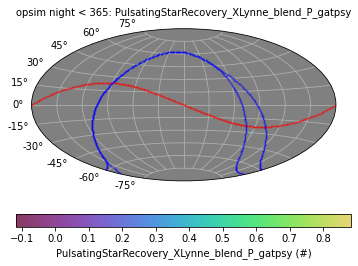

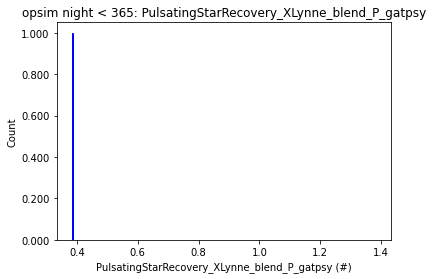

In [13]:
g.plotAll(closefigs=False)


In [13]:
#Turning complex metrics into scalars with "reduce" functions


'\nTurning complex metrics into scalars with "reduce" functions\n'